## Conceitos base sobre CLASSIFICAÇÃO (TAREFA SUPERVISIONADA), com ALGORITMO DE K-VIZINHOS MAIS PRÓXIMOS (KNN)

KNN: classificação - aprendizado supervisionado - considera a proximidade entre dados, permitindo realizar predições (classificação Sim ou Não, etc.) ou predição do tipo regressão com o KNNR. Considera que dados similares tendem a estar concentrados na mesma região do espaço quando submetidos à dispersão.
Funciona bem para classes linearmente separáveis, também para não lineares, mas para estas últimas uma rede neural é melhor. Normalmente o K é ímpar para evitar 'dúvida' na classificação, algo como [9,11] mas pode-se ir testando a partir de 1 checando a acurácia

Baseado em medidas no espaço cartesiano entre os pontos:
- Euclidiana
- Manhattan
- Minkowski: generalização entre Euclidiana (p = 2) e Manhattan (p = 1). No sklearn tem que setar o p, pois usa Minkowski
- Jaccard

KNN calcula distância para todos os objetos. Pode ter problema de desempenho a depender do tamanho do dataset e features

#### 1) importando classes comuns em ML

In [47]:
import numpy as np # manipulação numérica
import pandas as pd #análise de dados
import matplotlib.pyplot as plt #dataviz
import seaborn as sb #dataviz
%matplotlib inline


Iris Flower DATASET: https://www.kaggle.com/arshid/iris-flower-dataset

In [48]:
df = pd.read_csv('datasets/iris.csv') #df (dataframe - objeto pandas estruturado)
df.columns #retorna colunas do dataframe (características)

Index(['Id', 'SepalLengthCm', 'SepalWidthCm', 'PetalLengthCm', 'PetalWidthCm',
       'Species'],
      dtype='object')

In [49]:
db = df.copy() # mantenho db como cópia de df completo, para gerar um dataframe processado

In [50]:
#remover a coluna Id, pois não é útil à análise
db.drop(columns=['Id'], axis=1, inplace=True)

In [51]:
db.columns

Index(['SepalLengthCm', 'SepalWidthCm', 'PetalLengthCm', 'PetalWidthCm',
       'Species'],
      dtype='object')

In [52]:
#descrevendo a frequencia da coluna categorica. Neste caso é a própria coluna target (Species)
db.describe(include=object) # include='all'

,Species
count,150
unique,3
top,Iris-setosa
freq,50


In [53]:
db.describe() # aqui mostra só colunas numéricas não categóricas, estatísticas descritivas

,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm
count,150.000000,150.000000,150.000000,150.000000
mean,5.843333,3.054000,3.758667,1.198667
std,0.828066,0.433594,1.764420,0.763161
min,4.300000,2.000000,1.000000,0.100000
25%,5.100000,2.800000,1.600000,0.300000
50%,5.800000,3.000000,4.350000,1.300000
75%,6.400000,3.300000,5.100000,1.800000
max,7.900000,4.400000,6.900000,2.500000


#### Mudando o nome da coluna Species para target

In [54]:
db.rename(columns={'Species': 'target'}, inplace=True) # inplace = True não cria novo dataframe, altera o atual - case sensitive




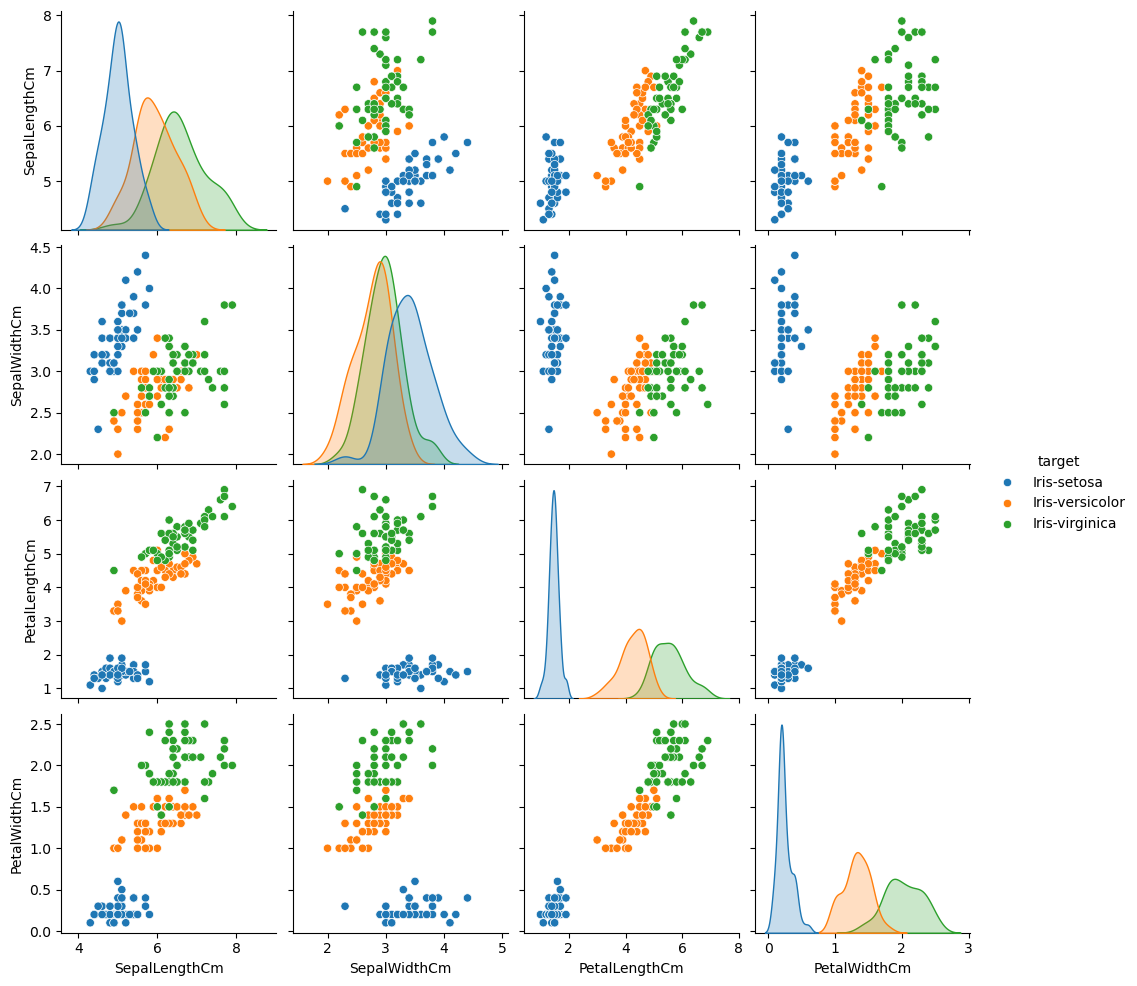

In [55]:
sb.pairplot(db, hue='target') # dispersão entre as colunas de dados, sem a coluna de classificação SPECIES:target

In [56]:
from sklearn import preprocessing
encoder = preprocessing.LabelEncoder() # Instancia um ENCODER, que irá transformar as classes categóricas de espécies em números

# aplica o encoder à coluna target e salva o resultado em nova coluna 'target_encoded'
db['target_encoded'] = encoder.fit_transform(db['target'])

print(encoder.classes_) #0: setosa, 1: versicolor, 2:virginica



['Iris-setosa' 'Iris-versicolor' 'Iris-virginica']


#### Apenas para exemplificar uma query

In [57]:
#db[db['target']=='Iris-virginica']

#### CASO 1) Remover do dataframe processado a coluna target categórica, target-encoded, pois já contém a classificação. A ideia é rodar o knn para ele fazer a classificação e comparar com a classificação já existente. Vamos criar um array para as features X

In [58]:
# db se mantém com as colunas alvo
X = np.array(db.drop(columns=['target','target_encoded'], axis=1)) # cria array numpy a partir do dataframe, removendo a coluna 'target'. axis = 1 informa que target é coluna e não linha

#### a) Neste primeiro caso, estamos considerando todas as características/features relevantes

In [59]:
#X

#### a.1) Separar as classes do dataframe em um array

In [60]:
y = np.array(db['target_encoded']) #coluna alvo numérica (exemplos)
y

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

#### a.2) Importar classe do algoritmo KNN, da lib scikit-learn

In [72]:
from sklearn.neighbors import KNeighborsClassifier

from sklearn.model_selection import train_test_split #separar conjunto de treino e de teste

from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report #algumas métricas de avaliação do modelo

#### a.3) Instancia um modelo da classe KNN classifier, com 3 vizinhos

In [62]:
knn_model = KNeighborsClassifier(n_neighbors=3)

#### a.4) Dividir conjuntos de treino e teste. O random_state é comum em ML, para permitir, se desejável na fase de testes, a reprodutibilidade dos resultados, ao setar uma semente (seed) fixa. Se deixar vazio, a cada RUN, o resultado varia. Ao comparar diferentes algoritmos, usar mesma semente, mesmo set de dados, senão como comparar? Algum dataset pode privilegiar determinado algoritmo, viés!

In [63]:
# treino com 70%, valida com 30%
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=30)

#### a.5) Aqui ocorre o treino do modelo, ajuste do modelo com base nos arrays X (features) e y (target)

In [64]:
knn_model.fit(X_train, y_train) # Treino com todas as features !!!

KNeighborsClassifier(n_neighbors=3)

#### a.6) Aqui é gerada a predição de cada linha observação de X_test e salvo em y_pred. 

In [65]:
s = y_test.size

y_pred = [] #y_hat (estimativa de y, dada pelo modelo KNN)
for i in range(s):
    y_pred.append(knn_model.predict([X_test[i,:]])) # vetor contendo as features

print(y_pred)

[array([0]), array([0]), array([0]), array([2]), array([1]), array([1]), array([2]), array([2]), array([1]), array([2]), array([0]), array([2]), array([1]), array([1]), array([0]), array([1]), array([0]), array([0]), array([0]), array([2]), array([1]), array([0]), array([0]), array([0]), array([2]), array([2]), array([2]), array([2]), array([0]), array([1]), array([2]), array([1]), array([2]), array([2]), array([2]), array([2]), array([1]), array([2]), array([1]), array([2]), array([2]), array([2]), array([0]), array([1]), array([2])]


#### a.7) Obtendo métricas de desempenho

In [66]:
print('Medindo a acurácia do KNN (%): {0:.2f}'.format(accuracy_score(y_test, y_pred, normalize=True)*100)) #normalize=True, fração dos corretos

Medindo a acurácia do KNN (%): 93.33


In [68]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        13
           1       0.92      0.85      0.88        13
           2       0.90      0.95      0.92        19

    accuracy                           0.93        45
   macro avg       0.94      0.93      0.93        45
weighted avg       0.93      0.93      0.93        45



In [70]:
cm = confusion_matrix(y_test, y_pred)

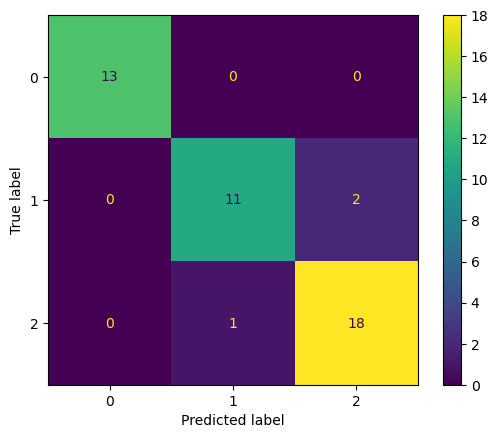

In [73]:
visual_cm = ConfusionMatrixDisplay(confusion_matrix=cm,
                                   display_labels=knn_model.classes_)
visual_cm.plot()

### Exercícios:
##### a) retorne ao item a.3) e altere o hiperparâmetro (que não depende dos dados) n_neighbors para 5, depois 1, depois 10. Para cada alteração, executar da célula onde se encontra a.3 para baixo, e anotar o que aconteceu com a acurácia
##### b) mantenha n_neighbors no valor que deu melhor resultado E retorne à célula onde é criado o vetor X de features. Vamos testar duas situações:
##### b.1) apenas as 2 features de sépalas: X = np.array(db.drop(columns=['target','target_encoded','PetalLengthCm', 'PetalWidthCm'], axis=1))
#####      Execute todas as células desta para baixo e veja se altera a acurácia e demais métricas. Compare com o caso onde usa as 4 features
##### b.2) apenas as 2 features de pétalas: X = np.array(db.drop(columns=['target','target_encoded','SepalLengthCm', 'SepalWidthCm'], axis=1))
#####      Execute todas as células desta para baixo e veja se altera a acurácia e demais métricas. Compare com o caso onde usa as 4 features 